In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord 
from astropy.nddata import Cutout2D
from astropy.time import Time
import astropy.units as u
from astropy.visualization import ImageNormalize, ZScaleInterval, LogStretch
print('imported libraries')

imported libraries


In [15]:
# Set target coordinates and cutout size
target_coord = SkyCoord(ra=202.951993 * u.deg, dec=-1.285494 * u.deg, frame='icrs')
cutout_size = 10 * u.arcsec
fits_dir = "../../../../shared/hsc_images_ra=202.95deg_dec=-1.28deg_radius=0.02deg/"

# Proper motion data (mas/yr)
ra = 202.951993
dec = -1.285494
pm_ra = -414.209178     # in mas/yr
pm_dec = -1041.278255   # in mas/yr
ra_cos_dec = pm_ra / np.cos(np.radians(dec))
print('defined vars')

defined vars


Running loop


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


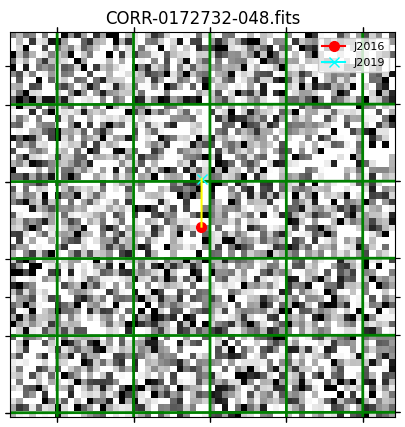

/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


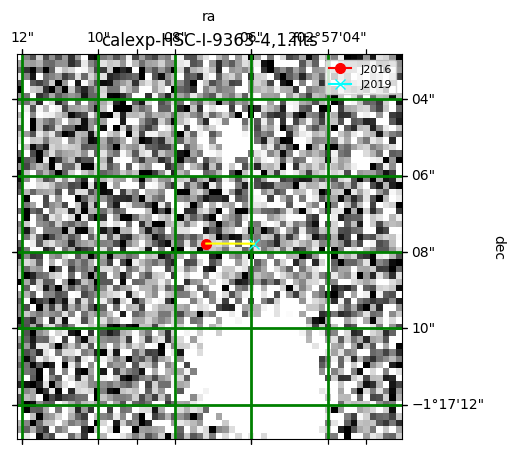

/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


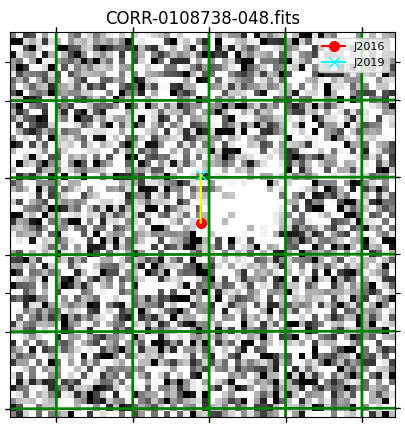

In [ ]:
print('Running loop')
# Loop through all FITS files
for fname in os.listdir(fits_dir):
    if ((not fname.endswith('.fits')) or
     (not fname.startswith('CORR-0108738')) and 
     (not fname.startswith('CORR-0172732')) and
     (not fname.startswith('calexp-HSC-I-9363'))):
        continue
    fpath = os.path.join(fits_dir, fname)
    try:
        with fits.open(fpath) as hdul:
            for hdu in hdul:
                if hdu.data is not None:
                    try:
                        wcs = WCS(hdu.header)
                        cutout = Cutout2D(hdu.data, target_coord, cutout_size, wcs=wcs)

                        # Convert proper motion star position to pixel coordinates
                        pm_star = SkyCoord(ra=ra * u.deg, 
                                           dec=dec * u.deg, 
                                           pm_ra_cosdec=ra_cos_dec*u.mas/u.yr, 
                                           pm_dec=dec*u.mas/u.yr,
                                           obstime=Time('J2016')
                        )
                        
                        # Convert to pixel position on the cutout WCS
                        origin = skycoord_to_pixel(pm_star, cutout.wcs)
                    
                        three_years = pm_star.apply_space_motion(new_obstime=Time('J2019'))
                        end_vec = skycoord_to_pixel(three_years, cutout.wcs)
                        # print('Pixel Coordinates of vec tip:',end_vec)
                        
                        # Make the plot
                        fig = plt.figure(figsize=(5, 5))
                        ax = fig.add_subplot(111, projection=cutout.wcs)
                        vmin, vmax = np.percentile(cutout.data, [5, 75])
                        # if 'calexp' in fpath: cutout.data = np.rot90(cutout.data)
                        ax.imshow(cutout.data, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
                        overlay = ax.get_coords_overlay('icrs')
                        overlay.grid(color='green', linestyle='solid', alpha=1, linewidth=2)
                        ax.coords[0].set_ticklabel_visible(False)
                        ax.coords[1].set_ticklabel_visible(False)
                        ax.set_title(f'{fname}')
                        ax.plot(*origin, marker='o', color='red', markersize=7, label='J2016')
                        ax.plot(*end_vec, marker='x', color='cyan', markersize=7, label='J2019')
                        ax.plot([origin[0], end_vec[0]], [origin[1], end_vec[1]], color='yellow', linestyle='solid')
                        ax.legend(loc='upper right', fontsize=8)
                        plt.show()
                        break
                    except Exception as e:
                        if str(e) != 'Arrays do not overlap.' and str(e) != 'WCS should contain celestial component':
                            print(f"[Inner Error] {fname}: {e}")
                        continue
    except Exception as e:
        print(f"[Outer Error] Skipped {fname}: {e}")
print('completed loop')

In [13]:
# std lib
from getpass import getpass
import warnings  
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning) # to quiet Astropy warnings

# 3rd party
from numpy.core.defchararray import startswith
import numpy as np
import pylab as plt
import matplotlib
%matplotlib inline

from pyvo.dal import sia
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb

# Data Lab
from dl import queryClient as qc, storeClient as sc, authClient as ac
print('imported libraries')

imported libraries


/var/tmp/ipykernel_66495/588140120.py:8: DeprecationWarning: numpy.core.defchararray is deprecated and has been renamed to numpy._core.defchararray. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.defchararray.startswith.
  from numpy.core.defchararray import startswith


In [10]:
token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()

Enter user name: (+ENTER)  joaopassos
Enter password: (+ENTER)  ········


'joaopassos'

In [19]:
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_dr2_se"
svc_stripe82 = sia.SIAService(DEF_ACCESS_URL)
ra = 42.817451981441494 # in degrees
dec = -3.8882601693023133 # in degrees
fov = 0.0022 # in degrees (~10 arcsecs)

In [20]:
imgTable = svc_stripe82.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
imgTable

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
des_dr2_se,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00598299_g_c60_r3630p01_immasked.fits.fz&extn=2&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0022050756560735743,0.0022",image/fits,14506,,,3,0,0,2,[2048 4096],,,[-0.13152],,des_dr2_se,,DES DR2,archival,,,DECam,,,,ivo://datalab.noirlab/vo#ivoa_des_dr2_se.siav1:ivo://datalab.noao/des_dr2_se/D00598299_g_c60_r3630p01_immasked.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00598299_g_c60_r3630p01_immasked.fits.fz&extn=2&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0022050756560735743,0.0022&preview=true",,,42.7692,-3.85582,--,,,--,-9.28332e-41,9.28332e-41,--,--,--,--,--,--,,,,,0,DES DR2,0,image,0,0,,0,,Stack,,,0
des_dr2_se,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00279790_g_c44_r3701p01_immasked.fits.fz&extn=1&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0022050756560735743,0.0022",image/fits,14661,,,3,0,0,2,[2048 4096],,,[-0.131],,des_dr2_se,,DES DR2,archival,,,DECam,g DECam SDSS c0001 4720.0 1520.0,,,ivo://datalab.noirlab/vo#ivoa_des_dr2_se.siav1:ivo://datalab.noao/des_dr2_se/D00279790_g_c44_r3701p01_immasked.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00279790_g_c44_r3701p01_immasked.fits.fz&extn=1&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0022050756560735743,0.0022&preview=true",,,42.7686,-3.92721,--,,,--,0.0,0.0,--,--,--,--,--,--,,,,,0,DES DR2,0,image,0,0,,0,,Stack,,,0
des_dr2_se,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00279790_g_c44_r3701p01_immasked.fits.fz&extn=2&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0022050756560735743,0.0022",image/fits,14661,,,3,0,0,2,[2048 4096],,,[-0.131],,des_dr2_se,,DES DR2,archival,,,DECam,,,,ivo://datalab.noirlab/vo#ivoa_des_dr2_se.siav1:ivo://datalab.noao/des_dr2_se/D00279790_g_c44_r3701p01_immasked.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00279790_g_c44_r3701p01_immasked.fits.fz&extn=2&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0022050756560735743,0.0022&preview=true",,,42.7686,-3.92721,--,,,--,-9.27772e-41,9.27772e-41,--,--,--,--,--,--,,,,,0,DES DR2,0,image,0,0,,0,,Stack,,,0
des_dr2_se,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00279781_i_c44_r3701p01_immasked.fits.fz&extn=1&POS=42.817451981441494,-3.8882601693023133&SIZE=0.0022050756560735743,0.0022",image/fits,14594,,,3,0,0,2,[2048 4096],,,[-0.13102],,des_dr2_se,,DES DR2,archival,,,DECam,i DECam SDSS c0003 7835.0 1470.0,,,ivo://datalab.noirlab/vo#ivoa_des_dr2_se.siav1:ivo://datalab.noao/des_dr2_se/D00279781_i_c44_r3701p01_immasked.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2_se&siaRef=D00279781_i_c44_r3701p01_immasked.fits.fz&extn=1&POS=42.817451981441494,-3.8882601693023133&SIZE=0.002205075

In [21]:
sel = (imgTable['proctype'].astype(str)=='Stack') & (imgTable['prodtype'].astype(str)=='image') & (startswith(imgTable['obs_bandpass'].astype(str),'r'))

In [23]:
row = imgTable[sel][1]
url = row['access_url']#.decode() # get the download URL
filename = download_file(url,cache=True,show_progress=False,timeout=120)
hdu = fits.open(filename)[0]
image = hdu.data
hdr = hdu.header
wcs = WCS(hdr) 

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

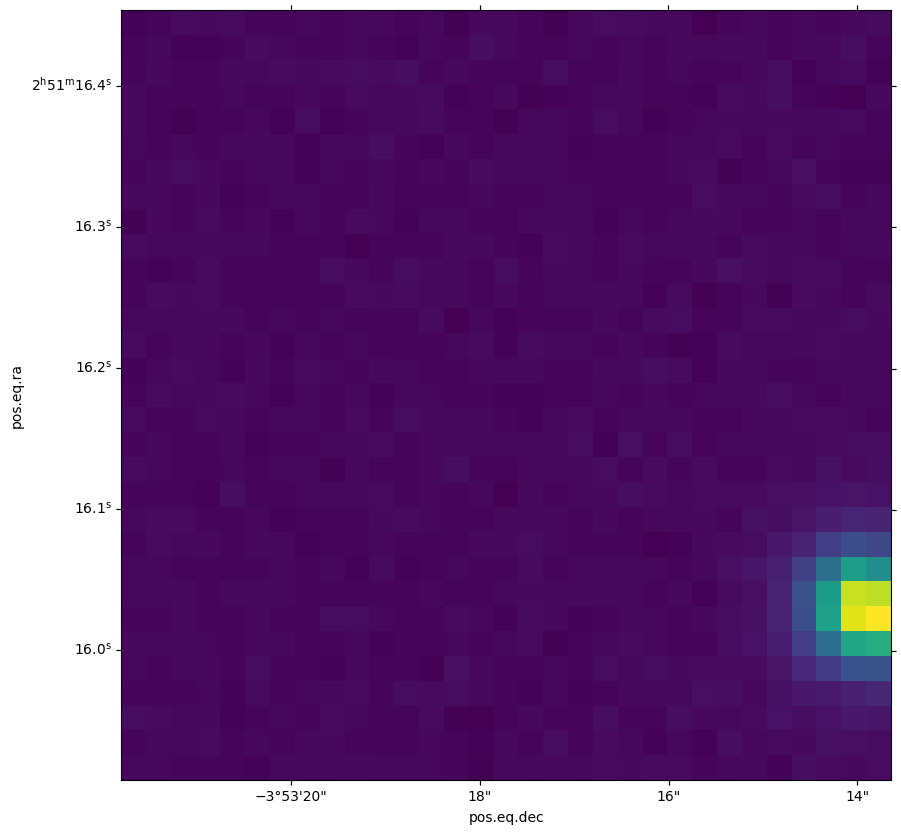

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=wcs)
ax.imshow(image)
plt.colorbar()
plt.show()